### **Due Date**
9/26/2024 at 11:59PM EST

# **Introduction**

Welcome to Assignment 2 of 4756. In this assignment, you will train an agent using demonstrations from an expert. Concretely, you will:
* Implement behavior cloning (BC) and dataset aggregation (DAgger) methods
* **CS 5756:** Get imitation learning working under causal confounds

You will use the Hopper agent for this assignment, which is part of Gym’s Mujoco Environments. Refer to the Gym website for more details about the [Hopper environment](https://gymnasium.farama.org/environments/mujoco/hopper/).


Please read through the following paragraphs carefully, as they will apply to this and all future assignments.

**Getting Started:** This assignment should be completed in [Google Colab](https://colab.research.google.com/). In order to access the python files bc.py and dagger.py which you will be editing, it is necessary to first upload the folder A2_FILES to your google drive and then mount your Google Drive in Colab. To do so, carefully follow the directions below in the section **Mounting Google Drive to Colab**, or reference the instructions [here](https://saturncloud.io/blog/how-to-import-python-files-in-google-colaboratory/). Additionally, make sure to switch your runtime type to T4 GPU; this will help speed up the training process.

**Important Note on Colab:** Some parts of this assignment can still take a while. The course staff have made several changes to improve this since the last iteration of the course. However, Colab has some restrictions that we cannot get around. The most common problem is students' computers falling asleep during execution of a cell. We suggest supervising your computer or changing its sleep settings to mitigate this. If possible, doing the whole assignment in one sitting will mitigate having to rerun BC Training too many times which can help. It's also good to note that each Colab user gets a limited continuous time to use the T4 GPU runtime, so if you run out, you can wait until a later day when you have more time on the GPUs or run it slower on a CPU runtime. Because of this, it is recommended to start early.

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers as lower bounds, you are not expected to replicate them exactly); however, it will be important to make an effort to justify your approach which led to the obtained results. Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Install and Import Dependencies**

In [2]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gym

!pip install free-mujoco-py
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install imageio==2.4.1
!pip install -U colabgymrender
!pip install mujoco

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [31]:
import gym
import torch.nn as nn
import torch
import numpy as np
import random
import tqdm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [4]:
# Setting the seed to ensure reproducability
def reseed(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

reseed(42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Mounting Google Drive in Colab**

Before you complete this step, make sure that you have uploaded the folder A2_FILES to your Google Drive. Once you have done that, you need to mount your Google Drive in Colab. In order to do so, run the cell below. Running this cell will prompt you to authorize Colab to access your drive. Follow the instructions to complete the authorization process.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Next, locate A2_FILES on the left panel in Colab. To do so, navigate to Files/drive/MyDrive. At this point, you should see the contents of your Google Drive. Locate A2_FILES in your drive, and if necessary, modify the cell below such that you are correctly indicating the file path to A2_FILES. You will append the path to A2_FILES to the system path. If you have completed this step correctly, you should be able to successfully import the BC and DAgger modules into this notebook.

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Fall_2024/Imitation_Learning/A2_FILES')

### **Setting Up the Environment**

In [7]:
def make_env(env_id, seed=42, p_tremble=0.0):
    env = gym.make(env_id, render_mode=None) # Change to render_mode='rgb_array' to render
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env
env = make_env('Hopper-v3')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Hopper-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

### **Visualizing the Hopper environment with random actions**

We have provided functions to visualize the environment and compute rewards on the Hopper environment with random actions. Looking through this code will help you get familiarized with the environment, and set you up for the next parts in this assignment.

We disabled the visualizations by default since they greatly slow down the evaluation, but feel free to turn it on if you're interested. You'll have to set visualize to True in the cell below and render_mode to 'rgb_array' when setting up the environment.

In [8]:
NUM_TRAJS = 50
visualize = False # set to false in order to disable rendering code
if visualize:
    plt.axis('off')
total_random_reward = 0
i = 0
for _ in range(NUM_TRAJS):
  done = False
  obs = env.reset(seed = i)
  while not done:
      i += 1
      if i%5==0 and visualize:
          ipythondisplay.clear_output(wait=True)
          screen = env.render()
          plt.imshow(screen[0])
          ipythondisplay.display(plt.gcf())
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      total_random_reward += reward
      if done:
          break
total_random_reward /= NUM_TRAJS
print("Total Reward using Random Actions = ", (total_random_reward))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total Reward using Random Actions =  17.595136980994347


**Approximate expected reward for total reward using random actions: 10**

In [9]:
# Download Hopper expert policy
!wget https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt

--2024-09-27 19:01:17--  https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt [following]
--2024-09-27 19:01:17--  https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284515 (278K) [application/octet-stream]
Saving to: ‘hopper.pt.1’

hopper.pt.1         100%[===================>] 277.85K  --.-KB/s    in 0.04s   


### **Neural Networks in PyTorch**

We have provided some code for implementing simple neural networks (fully connected, multilayer perceptrons) in PyTorch, including the ExpertActor and Learner classes. We have also provided code for checkpointing for saving your best performing model. If you wish to learn more about how to construct and train neural networks in PyTorch, check out the tutorials on [pytorch.org](https://pytorch.org/).

### ExpertActor Class

In [10]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ExpertActor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.action_space.high - env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.action_space.high + env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def get_expert_action(self, obs, random_prob=0.0):
        if np.random.random() < random_prob:
            return env.action_space.sample()
        else:
            action = self.get_action(torch.tensor([obs]).float().to(device))
            return np.array(action[0][0].detach().cpu())

ckpt_path = "hopper.pt"
expert = ExpertActor(env).to(device)
expert.load_state_dict(torch.load(str(ckpt_path), map_location='cpu'))

<ipython-input-10-0ef05d14b2e1>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  expert.load_state_dict(torch.load(str(ckpt_path), map_location='cpu'))


<All keys matched successfully>

### Learner Class

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Learner(nn.Module):
    def __init__(self, env, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, np.prod(env.action_space.shape))

        self.env = env
        self.random_prob = random_prob

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor([obs]).float().to(device))
        return np.array(action[0].detach().cpu())

### Checkpointing Functions

In [12]:
def get_checkpoint_path(algo):
    """Return the path to save the best performing model checkpoint.

    Parameters:
        algo (str)
          Indicates which algorithm will be used to train the model

    Returns:
        checkpoint_path (str)
            The path to save the best performing model checkpoint
    """
    if algo == "bc":
      return 'best_bc_checkpoint.pth'
    elif algo == "dagger":
      return 'best_dagger_checkpoint.pth'
    return 'best_model_checkpoint.pth'

def load_model_checkpoint(checkpoint_path):
    """Load a model checkpoint from disk.

    Parameters:
        checkpoint_path (str)
            The path to load the checkpoint from

    Returns:
        model (torch.nn.Module)
            The model loaded from the checkpoint
    """
    model = Learner(env)
    model.load_state_dict(torch.load(checkpoint_path))
    return model

### **Visualizing the Hopper environment with the expert policy**

We have provided a visualization for computing rewards using the expert policy on the Hopper environment.

In [13]:
NUM_TRAJS = 50
visualize = False # set to false in order to disable rendering code
if visualize:
    plt.axis('off')
reseed(1)
total_expert_reward = 0
i = 0
for _ in range(NUM_TRAJS):
  done = False
  obs = env.reset(seed = i)
  while not done:
    i += 1
    if visualize and i%20==0:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = expert.get_expert_action(obs)
    obs, reward, done, info = env.step(action)
    total_expert_reward += reward
    if done:
        break
total_expert_reward /= NUM_TRAJS
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Random Actions = {total_random_reward}\n")

<ipython-input-10-0ef05d14b2e1>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  action = self.get_action(torch.tensor([obs]).float().to(device))


Total Reward using Expert Policy = 2936.2653679659766
Total Reward using Random Actions = 17.595136980994347



**Approximate expected reward for total reward using expert policy: 2725**

### **Data collection**

We have provided some code to collect 100 demonstrations using the expert policy. To collect a different number of  trajectories, change the value of the NUM_TRAJS variable.

### Collecting offline data, processing it, and splitting it into training and validation sets.

In [14]:
### Collecting trajectories (i.e. demonstrations) using the expert policy
NUM_TRAJS = 100
observations, actions = [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS), position=0, leave=True):
    done = False
    obs = env.reset(seed = traj_num)
    while not done:
        with torch.no_grad():
            action = expert.get_expert_action(obs)
            observations.append(obs)
            actions.append(action)
            obs, reward, done, info = env.step(action)
        if done:
            break
train_obs = observations[:int(0.5*len(observations))]
train_actions = actions[:int(0.5*len(actions))]
validation_obs = observations[int(0.5*len(observations)):]
validation_actions = actions[int(0.5*len(actions)):]

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


# **Q1: Behavior Cloning (BC)**

To begin, fill in the implementation for the training loop function in **bc.py** found in **A2_FILES**. We provide the loss function and optimizer already, just iterate through your dataloader and return the updated policy!

You'll also measure the validation loss at each iteration to check for overfitting.

Once you finish the training loop implementation, it is now time to build up your agents! **Behavior cloning (BC)** is the simplest imitation learning algorithm, where we perform supervised learning on the given (offline) expert dataset. We either do this via log-likelihood maximization (cross-entropy minimization) in the discrete action case, or mean-squared error minimization (can also do MLE) in the continuous control setting.

If implemented correctly, training your BC model should take roughly 15 minutes.

### Train Behavior Cloning (BC) Model on the gathered trajectories and check for overfitting
#### Expected Runtimes
CPU: ~35 Minutes\
GPU: ~15 Minutes\

The resulting graph should show a clear downward trend without curving back up at the right side. If the validation loss increases at the end, it indicates overfitting.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1500/1500 [19:50<00:00,  1.26it/s]


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

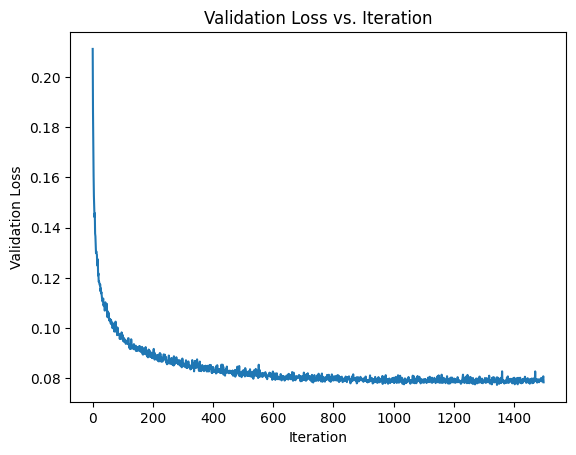

In [23]:
%load_ext autoreload
%autoreload 2
import bc

bc_learner = Learner(env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
bc.train(bc_learner, torch.tensor(train_obs).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_obs).to(device), torch.tensor(validation_actions).to(device), checkpoint_path, num_epochs = 1500)

### Visualize the learner policy and compare rewards with expert policy

In [24]:
NUM_TRAJS = 50
visualize = False # set to false in order to disable rendering code
reseed(2)
total_learner_reward = 0
i= 0
for _ in range(NUM_TRAJS):
  done = False
  obs = env.reset(seed = i)
  while not done:
    i += 1
    if visualize and i%20==0:
      ipythondisplay.clear_output(wait=True)
      screen = env.render()
      plt.imshow(screen[0])
      ipythondisplay.display(plt.gcf())
    with torch.no_grad():
      action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
      break
total_learner_reward /= NUM_TRAJS
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

Total Reward using Expert Policy = 2936.2653679659766
Total Reward using Learned Policy = 1429.873870118917



**Approximate expected reward for total reward using learned policy: 1000**

Once this is working, make sure 'best_bc_checkpoint.pth' is saved locally for your submission and so you do not have to train BC again. Colab will delete this when the runtime disconnects, so you want a local backup.

# **Q2: DAgger**

**Dataset aggregation (DAgger)** is a fundamentally interactive algorithm, where we can query the expert any time we want to get information about how to proceed. This allows for significantly more freedom for the learner, as it can ask the expert anywhere and not be limited by the dataset that it is given to learn from.

**Can we overcome shaky hands with DAgger?** Fundamentally, this algorithm allows the learner to recover from bad states and should lead to much better performance than simply behavior cloning a fixed set of expert demonstrations. For this portion of the assignment, you will interact with the environment using the learner policy with random actions. You will do so in **dagger.py** found in **A2_FILES**.

Remember to initialize the DAgger policy with the already learned BC policy and your dataset with the already collected expert demonstrations for BC.



### Initialize DAgger with BC

In [25]:
dagger_learner = Learner(env)
dagger_learner.load_state_dict(torch.load('best_bc_checkpoint.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)

<ipython-input-25-231093fba4cb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dagger_learner.load_state_dict(torch.load('best_bc_checkpoint.pth'))


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Interact with the environment using the learner policy
#### Expected Runtimes
CPU: ~25 Minutes\
GPU: ~10 Minutes

In [26]:
# Reload code in q1 and q2 modules without having to restart the kernel
%load_ext autoreload
%autoreload 2
import dagger

checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
dagger.interact(env, dagger_learner, expert, torch.tensor(train_obs).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_obs).to(device), torch.tensor(validation_actions).to(device), checkpoint_path, seed, num_epochs = 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 200/200 [02:34<00:00,  1.29it/s]


After interaction 0, reward = 3305.621676258011


100%|██████████| 200/200 [03:02<00:00,  1.10it/s]


After interaction 1, reward = 2692.670740251539


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


After interaction 2, reward = 2507.4432247264617


100%|██████████| 200/200 [03:38<00:00,  1.09s/it]


After interaction 3, reward = 1462.785099787639


100%|██████████| 200/200 [03:45<00:00,  1.13s/it]


After interaction 4, reward = 2302.047554186449


In [27]:
NUM_TRAJS = 50
visualize = False # set to false in order to disable rendering code
reseed(2)
total_learner_reward = 0
i = 0
for _ in range(NUM_TRAJS):
  done = False
  obs = env.reset(seed = i)
  while not done:
    i += 1
    if visualize and i%20==0:
          ipythondisplay.clear_output(wait=True)
          screen = env.render()
          plt.imshow(screen[0])
          ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = dagger_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
total_learner_reward /= NUM_TRAJS
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using DAgger Learned Policy = {total_learner_reward}\n")

Total Reward using Expert Policy = 2936.2653679659766
Total Reward using DAgger Learned Policy = 2267.181605817488



**Approximate expected reward for DAgger learner: 2000**\
This means at least one of the five interactions should have a reward ~= 2000, not necessarily that the last interaction should.

# **CS 5756: Causal Confounds**

Congratulations, you made it! You have implemented your first few “deep” imitation learning algorithms in PyTorch.

With that in mind, let’s dig a little deeper. A common problem in the real world is hidden information. What if parts of the robot's state are hidden from the learner? How well does imitation learning do when the expert has full state knowledge, but the learner does not?

You will need to:
* Create a “partially observable” Hopper environment where the last observation index (refer to Gym documentation) is hidden from the learner (note that it’s still available to the expert!)
* Obtain rewards for both BC and DAgger. How well do BC and DAgger work for the partially observable Hopper environment? Explain the performance of both BC and DAgger relative to the fully observable case. Also explain how the performance difference between BC and DAgger changed due to the move to a partially observable environment.

**Note:** For this part, BC should just work if you did things right while DAgger will need some additional obfuscation logic. Please save this to a separate obfuscated_dagger.py file

**Hint:** Take a look [here](https://gymnasium.farama.org/api/wrappers/observation_wrappers/) for information on Observation Wrappers.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1500/1500 [18:51<00:00,  1.33it/s]


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

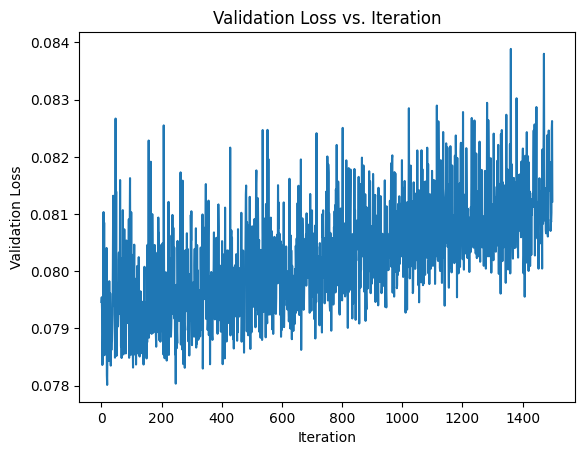

In [28]:
%load_ext autoreload
%autoreload 2
import bc
from gym.wrappers import TransformObservation
obs_env = TransformObservation(env, lambda obs: np.append(obs[:-1], np.array([0])))
obs_bc_learner = Learner(obs_env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
bc.train(bc_learner, torch.tensor(train_obs).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_obs).to(device), torch.tensor(validation_actions).to(device), checkpoint_path, num_epochs = 1500)

In [29]:
NUM_TRAJS = 50
visualize = False # set to false in order to disable rendering code
reseed(2)
total_learner_reward = 0
i= 0
for _ in range(NUM_TRAJS):
  done = False
  obs = obs_env.reset(seed = i)
  while not done:
    i += 1
    if visualize and i%20==0:
      ipythondisplay.clear_output(wait=True)
      screen = obs_env.render()
      plt.imshow(screen[0])
      ipythondisplay.display(plt.gcf())
    with torch.no_grad():
      action = obs_bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
      break
total_learner_reward /= NUM_TRAJS
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

Total Reward using Expert Policy = 2936.2653679659766
Total Reward using Learned Policy = 57.29694405329785



In [ ]:
obsc_dagger_learner = Learner(env)
obsc_dagger_learner.load_state_dict(torch.load('best_bc_checkpoint.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
obsc_dagger_learner.to(device)
# Reload code in q1 and q2 modules without having to restart the kernel
%load_ext autoreload
%autoreload 2
import obsc_dagger

checkpoint_path = get_checkpoint_path("obsc_dagger")
seed = 2
reseed(seed)
obsc_dagger.interact(env, obsc_dagger_learner, expert, torch.tensor(train_obs).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_obs).to(device), torch.tensor(validation_actions).to(device), checkpoint_path, seed, num_epochs = 200)

<ipython-input-40-b8231216e362>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obsc_dagger_learner.load_state_dict(torch.load('best_bc_checkpoint.pth'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


After interaction 0, reward = 9.248151114310545


100%|██████████| 200/200 [02:24<00:00,  1.39it/s]


After interaction 1, reward = 78.06401385495356


 18%|█▊        | 35/200 [00:25<02:11,  1.25it/s]

In [39]:
NUM_TRAJS = 50
visualize = False # set to false in order to disable rendering code
reseed(2)
total_learner_reward = 0
i = 0
for _ in range(NUM_TRAJS):
  done = False
  obs = env.reset(seed = i)
  while not done:
    i += 1
    if visualize and i%20==0:
          ipythondisplay.clear_output(wait=True)
          screen = env.render()
          plt.imshow(screen[0])
          ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = obsc_dagger_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
total_learner_reward /= NUM_TRAJS
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Obsc DAgger Learned Policy = {total_learner_reward}\n")

Total Reward using Expert Policy = 2936.2653679659766
Total Reward using Obsc DAgger Learned Policy = 1108.1345158184

